In [ ]:
# Mounting Google Drive locally and help you to save your trained model.
# More info https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
!pip install scikit-survival eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 14.6 MB/s 
     |████████████████████████████████| 216 kB 44.5 MB/s 
     |████████████████████████████████| 133 kB 54.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=1c9ca34cf9100da7915a0591be6ecd23845f2cb5fc77dd135e81f5d8bfa0d89e
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinj

In [2]:
# import scikit-survival
import sksurv

In [3]:
 # Example how to extract features and labels with startup_data using scikit-survival Python package
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
scooter_data = pd.read_csv(
    'cleaned_better_scooter.csv')
scooter_data.head()

,id,tte,need_repair,usage_length_days,manufactor,avg_complains,ride_miles
0,1,57.0,True,58.766838,C,21.3,6.2
1,2,736.0,False,56.447815,C,4.6,88.0
2,3,145.0,True,70.074472,B,1.8,88.4
3,4,275.0,True,54.742087,C,5.3,131.8
4,6,357.0,True,66.260541,A,0.7,60.0


In [5]:
from sksurv.datasets import get_x_y
from sksurv.util import Surv

surv_features, surv_labels_df = get_x_y(scooter_data,['need_repair','tte'], survival=False)
surv_labels = Surv.from_dataframe('need_repair','tte',surv_labels_df)
surv_labels[:10]

array([( True,  57.), (False, 736.), ( True, 145.), ( True, 275.),
       ( True, 357.), (False, 357.), ( True, 352.), ( True, 342.),
       ( True,   8.), ( True, 536.)],
      dtype=[('need_repair', '?'), ('tte', '<f8')])

In [6]:
surv_features.head()

,id,usage_length_days,manufactor,avg_complains,ride_miles
0,1,58.766838,C,21.3,6.2
1,2,56.447815,C,4.6,88.0
2,3,70.074472,B,1.8,88.4
3,4,54.742087,C,5.3,131.8
4,6,66.260541,A,0.7,60.0


# Task 1: KM

Text(0.5, 0, 'time $t$')

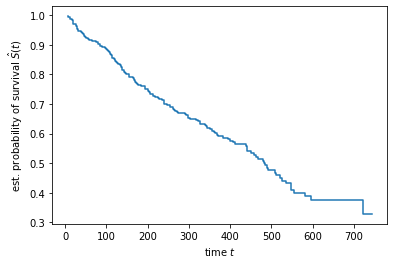

In [7]:
# KM model 
from sksurv.nonparametric import kaplan_meier_estimator
surv_time, surv_event = kaplan_meier_estimator(surv_labels["need_repair"], surv_labels["tte"])
plt.step(surv_time, surv_event, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

# Task 2: KM for different groups

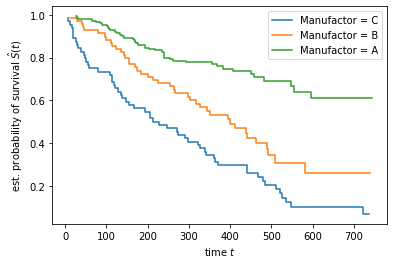

In [8]:
for manu in surv_features.manufactor.unique():
    mask_manu = surv_features["manufactor"] == manu
    usage_time, survival_prob = kaplan_meier_estimator(
        surv_labels["need_repair"][mask_manu],
        surv_labels["tte"][mask_manu])

    plt.step(usage_time, survival_prob, where="post",
             label="Manufactor = %s" % manu)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Task 3: Log rank test

In [9]:
# https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.compare.compare_survival.html#sksurv.compare.compare_survival

from sksurv.compare import compare_survival
logrank_sksurv = compare_survival(surv_labels, surv_features.manufactor.values, return_stats = True)
#chisq, pvalue, stats,covariance
logrank_sksurv[1]

5.503522413332893e-14

# Task 4: Cox and random survival forest

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.inspection import permutation_importance

In [11]:
surv_features.columns

Index(['id', 'usage_length_days', 'manufactor', 'avg_complains', 'ride_miles'], dtype='object')

In [12]:
surv_features = surv_features.drop('id', axis=1)

surv_features = pd.get_dummies(surv_features, 
                              drop_first=False,
                              columns=['manufactor'])
surv_features.head()

,usage_length_days,avg_complains,ride_miles,manufactor_A,manufactor_B,manufactor_C
0,58.766838,21.3,6.2,0,0,1
1,56.447815,4.6,88.0,0,0,1
2,70.074472,1.8,88.4,0,1,0
3,54.742087,5.3,131.8,0,0,1
4,66.260541,0.7,60.0,1,0,0


In [13]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(
    surv_features, surv_labels, test_size=0.25, random_state=random_state)

In [14]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:434: LinAlgWarning: Ill-conditioned matrix (rcond=4.07494e-21): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:434: LinAlgWarning: Ill-conditioned matrix (rcond=3.37558e-21): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:434: LinAlgWarning: Ill-conditioned matrix (rcond=2.58335e-21): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:434: LinAlgWarning: Ill-conditioned matrix (rcond=1.12793e-21): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:434: LinAlgWarning: Ill-conditioned matrix (rcond=5.

CoxPHSurvivalAnalysis()

In [15]:
pd.Series(estimator.coef_, index=X_train.columns)

usage_length_days    0.046203
avg_complains        0.068657
ride_miles           0.000240
manufactor_A         0.749481
manufactor_B         1.087117
manufactor_C         1.496347
dtype: float64

In [16]:
estimator.score(X_test, y_test)

0.7935560859188544

In [1]:
estimator.score(X_train, y_train)

NameError: name 'estimator' is not defined

In [ ]:
%%time
random_state = 20
sksurv_rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
sksurv_rsf.fit(X_train, y_train)

CPU times: user 3.43 s, sys: 240 ms, total: 3.67 s
Wall time: 2.57 s


RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [ ]:
sksurv_rsf.score(X_test, y_test)

0.8084725536992841

In [ ]:

%%time 
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(sksurv_rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

CPU times: user 19.1 s, sys: 4.82 s, total: 23.9 s
Wall time: 25.3 s


Weight,Feature
0.1702 ± 0.0608,avg_complains
0.0129 ± 0.0246,usage_length_days
0.0067 ± 0.0231,ride_miles
0.0019 ± 0.0102,manufactor_C
-0.0008 ± 0.0070,id
-0.0014 ± 0.0030,manufactor_B
-0.0014 ± 0.0097,manufactor_A


In [ ]:
# use the code in sksurv
%%time 
from sklearn.inspection import permutation_importance

result = permutation_importance(
    sksurv_rsf, X_test, y_test, n_repeats=15, random_state=random_state
)

pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

CPU times: user 16.7 s, sys: 4.24 s, total: 20.9 s
Wall time: 22.6 s


,importances_mean,importances_std
avg_complains,0.177705,0.036625
usage_length_days,0.017562,0.008803
ride_miles,0.013683,0.005791
manufactor_C,0.005052,0.004116
manufactor_B,0.001074,0.001528
manufactor_A,0.000994,0.004826


# Task 5: predict

In [ ]:
ten_scooters = pd.read_csv(
    'ten_scooters.csv')
ten_scooters = ten_scooters.drop('id',axis = 1)
ten_scooters

,usage_length_days,avg_complains,ride_miles,manufactor_A,manufactor_B,manufactor_C
0,56.447815,4.6,88.0,0,0,1
1,55.536086,1.4,54.0,1,0,0
2,53.058263,5.4,120.9,0,1,0
3,45.690505,1.2,72.0,1,0,0
4,64.647903,11.4,114.0,0,0,1
5,64.190669,7.8,73.0,0,0,1
6,52.026065,16.2,241.0,0,0,1
7,60.538276,11.4,246.0,0,1,0
8,45.211368,0.9,89.0,1,0,0
9,60.661483,2.1,98.0,0,0,1


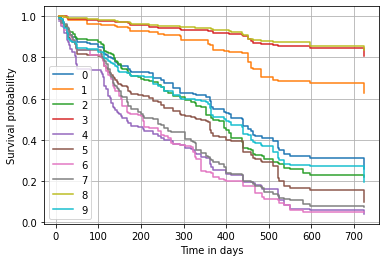

In [ ]:
surv = sksurv_rsf.predict_survival_function(ten_scooters, return_array=True)

for i, s in enumerate(surv):
    plt.step(sksurv_rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)